# Regularization in Computer vision

## Training a CNN

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [3]:
# Will download the dataset at first
trainset = CIFAR10('./data', train=True, download=True, transform=transform)
train_dataloader = DataLoader(trainset, batch_size=64, shuffle=True)
testset = CIFAR10('./data', train=False, download=True, transform=transform)
test_dataloader = DataLoader(testset, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


(-0.5, 273.5, 273.5, -0.5)

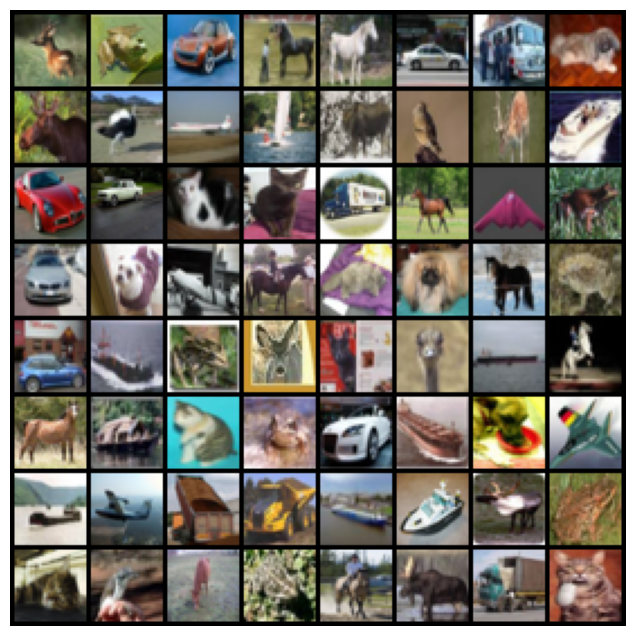

In [4]:
# Get a batch of images and labels
train_iter = iter(train_dataloader)
images, labels = next(train_iter)
# Denormalize the images
images = images / 2 + 0.5
# Compute a grid image for visualization
images = make_grid(images)
# Switch from channel first to channel last
images = np.transpose(images.numpy(), (1, 2, 0))
# Display the result
plt.figure(figsize=(14, 8))
plt.imshow(images)
plt.axis('off')

In [5]:
class LeNet5(nn.Module):
    def __init__(self, n_classes: int):
        super(LeNet5, self).__init__()
        self.n_classes = n_classes
        self.c1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0)
        self.s2 = nn.MaxPool2d(kernel_size=2)
        self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.s4 = nn.MaxPool2d(kernel_size=2)
        self.c5 = nn.Linear(400, 120)
        self.f6 = nn.Linear(120, 84)
        self.output = nn.Linear(84, self.n_classes)

    def forward(self, x):
        x = F.relu(self.c1(x))
        x = self.s2(x)
        x = F.relu(self.c3(x))
        x = self.s4(x)
        # Flatten the 2D-array
        x = torch.flatten(x, 1)
        x = F.relu(self.c5(x))
        x = F.relu(self.f6(x))
        output = F.softmax(self.output(x), dim=1)
        return output

In [6]:
# Instantiate the model
lenet5 = LeNet5(10)
# check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lenet5 = lenet5.to(device)
# Generate randomly one random 32x32 RGB image
random_data = torch.rand((1, 3, 32, 32), device=device)
result = lenet5(random_data)
print('Resulting output tensor:', result)
print('Sum of the output tensor:', result.sum())

Resulting output tensor: tensor([[0.0890, 0.1047, 0.1039, 0.1003, 0.0957, 0.0918, 0.0948, 0.1078, 0.0999,
         0.1121]], grad_fn=<SoftmaxBackward0>)
Sum of the output tensor: tensor(1.0000, grad_fn=<SumBackward0>)


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.001)

In [8]:
# Create empty lists to store the losses and accuracies
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

# Loop over 50 times
for epoch in range(50):  
    ## Train the model on the training set
    running_train_loss = 0.
    correct = 0.
    lenet5.train()
    for i, data in enumerate(train_dataloader, 0):
        # Get the inputs: data is a list of [inputs, labels]
        inputs, labels = data
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = lenet5(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # Add correct predictions for this batch
        correct += (outputs.argmax(dim=1) == labels).float().sum()
        # Compute loss for this batch
        running_train_loss += loss.item()
    # Compute and store loss and accuracy for this epoch
    train_epoch_loss = running_train_loss / len(train_dataloader)
    train_losses.append(train_epoch_loss)
    train_epoch_accuracy = correct / len(trainset)
    train_accuracy.append(train_epoch_accuracy)

    ## Evaluate the model on the test set
    running_test_loss = 0.
    correct = 0.
    lenet5.eval()
    with torch.no_grad():
        for i, data in enumerate(test_dataloader, 0):
            inputs, labels = data
            outputs = lenet5(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).float().sum()

        test_epoch_loss = running_test_loss / len(test_dataloader)
        test_losses.append(test_epoch_loss)
        test_epoch_accuracy = correct / len(testset)
        test_accuracy.append(test_epoch_accuracy)

    # Print stats
    print(f'[epoch {epoch + 1}] Training: loss={train_epoch_loss:.3f} accuracy={train_epoch_accuracy:.3f} |\
\t Test: loss={test_epoch_loss:.3f} accuracy={test_epoch_accuracy:.3f}')

print('Finished Training')

[epoch 1] Training: loss=2.124 accuracy=0.327 |	 Test: loss=2.093 accuracy=0.361
[epoch 2] Training: loss=2.038 accuracy=0.417 |	 Test: loss=2.014 accuracy=0.442
[epoch 3] Training: loss=2.001 accuracy=0.456 |	 Test: loss=1.978 accuracy=0.478
[epoch 4] Training: loss=1.972 accuracy=0.486 |	 Test: loss=1.950 accuracy=0.510
[epoch 5] Training: loss=1.945 accuracy=0.513 |	 Test: loss=1.935 accuracy=0.522
[epoch 6] Training: loss=1.929 accuracy=0.530 |	 Test: loss=1.949 accuracy=0.509
[epoch 7] Training: loss=1.910 accuracy=0.548 |	 Test: loss=1.915 accuracy=0.543
[epoch 8] Training: loss=1.897 accuracy=0.561 |	 Test: loss=1.912 accuracy=0.545
[epoch 9] Training: loss=1.886 accuracy=0.573 |	 Test: loss=1.908 accuracy=0.549
[epoch 10] Training: loss=1.876 accuracy=0.583 |	 Test: loss=1.900 accuracy=0.558
[epoch 11] Training: loss=1.866 accuracy=0.594 |	 Test: loss=1.891 accuracy=0.568
[epoch 12] Training: loss=1.859 accuracy=0.600 |	 Test: loss=1.900 accuracy=0.558
[epoch 13] Training: loss

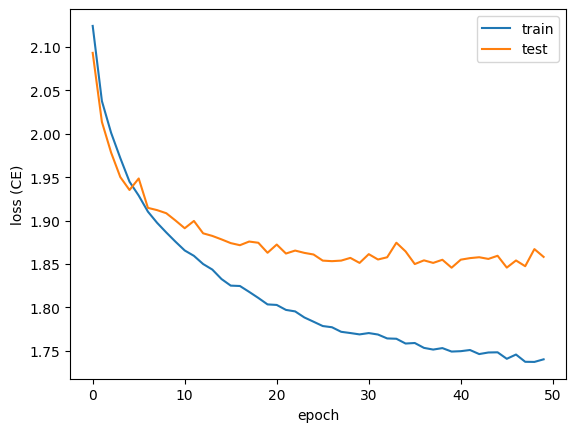

In [9]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('epoch')
plt.ylabel('loss (CE)')
plt.legend()
plt.show()

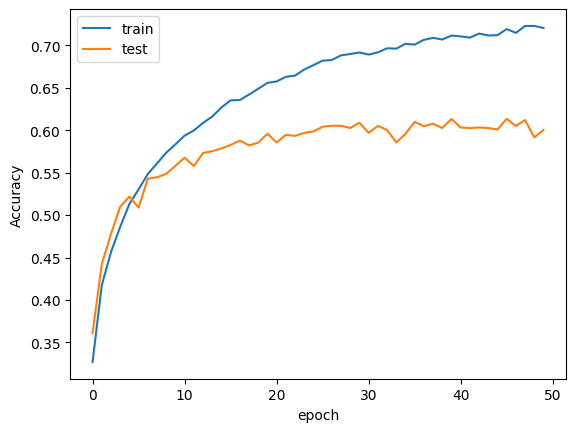

In [10]:
plt.plot(train_accuracy, label='train')
plt.plot(test_accuracy, label='test')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Regularizing a CNN with vanilla NN methods

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

In [3]:
# Instantiate the transformation to apply to images
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
# Instantiate the data loaders
trainset = CIFAR10('./data', train=True, download=True, transform=transform)
train_dataloader = DataLoader(trainset, batch_size=64, shuffle=True)
testset = CIFAR10('./data', train=False, download=True, transform=transform)
test_dataloader = DataLoader(testset, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class LeNet5(nn.Module):
    def __init__(self, n_classes: int):
        super(LeNet5, self).__init__()
        self.n_classes = n_classes
        self.c1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0, )
        self.s2 = nn.MaxPool2d(kernel_size=2)
        self.bnorm2 = nn.BatchNorm2d(6)
        self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.s4 = nn.MaxPool2d(kernel_size=2)
        self.bnorm4 = nn.BatchNorm1d(400)
        self.c5 = nn.Linear(400, 120)
        self.bnorm5 = nn.BatchNorm1d(120)
        self.f6 = nn.Linear(120, 84)
        self.bnorm6 = nn.BatchNorm1d(84)
        self.output = nn.Linear(84, self.n_classes)

    def forward(self, x):
        x = F.relu(self.c1(x))
        x = self.bnorm2(self.s2(x))
        x = F.relu(self.c3(x))
        x = self.s4(x)
        # Flatten the 2D-array
        x = self.bnorm4(torch.flatten(x, 1))
        x = self.bnorm5(F.relu(self.c5(x)))
        x = self.bnorm6(F.relu(self.f6(x)))
        output = F.softmax(self.output(x), dim=1)
        return output

In [5]:
# Instantiate the model
lenet5 = LeNet5(10)
# check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lenet5 = lenet5.to(device)
# Instantiate loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.001)

In [6]:
# Create empty lists to store the losses and accuracies
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

# Loop over 20 epochs
for epoch in range(20):  
    ## Train the model on the training set
    running_train_loss = 0.
    correct = 0.
    lenet5.train()
    for i, data in enumerate(train_dataloader, 0):
        # Get the inputs: data is a list of [inputs, labels]
        inputs, labels = data
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = lenet5(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # Add correct predictions for this batch
        correct += (outputs.argmax(dim=1) == labels).float().sum()
        # Compute loss for this batch
        running_train_loss += loss.item()
    # Compute and store loss and accuracy for this epoch
    train_epoch_loss = running_train_loss / len(train_dataloader)
    train_losses.append(train_epoch_loss)
    train_epoch_accuracy = correct / len(trainset)
    train_accuracy.append(train_epoch_accuracy)

    ## Evaluate the model on the test set
    running_test_loss = 0.
    correct = 0.
    lenet5.eval()
    with torch.no_grad():
        for i, data in enumerate(test_dataloader, 0):
            inputs, labels = data
            outputs = lenet5(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).float().sum()

        test_epoch_loss = running_test_loss / len(test_dataloader)
        test_losses.append(test_epoch_loss)
        test_epoch_accuracy = correct / len(testset)
        test_accuracy.append(test_epoch_accuracy)

    # Print stats
    print(f'[epoch {epoch + 1}] Training: loss={train_epoch_loss:.3f} accuracy={train_epoch_accuracy:.3f} |\
\t Test: loss={test_epoch_loss:.3f} accuracy={test_epoch_accuracy:.3f}')

print('Finished Training')

[epoch 1] Training: loss=2.009 accuracy=0.455 |	 Test: loss=1.932 accuracy=0.531
[epoch 2] Training: loss=1.915 accuracy=0.545 |	 Test: loss=1.891 accuracy=0.568
[epoch 3] Training: loss=1.876 accuracy=0.585 |	 Test: loss=1.872 accuracy=0.587
[epoch 4] Training: loss=1.851 accuracy=0.610 |	 Test: loss=1.849 accuracy=0.610
[epoch 5] Training: loss=1.834 accuracy=0.627 |	 Test: loss=1.849 accuracy=0.611
[epoch 6] Training: loss=1.818 accuracy=0.643 |	 Test: loss=1.845 accuracy=0.615
[epoch 7] Training: loss=1.804 accuracy=0.657 |	 Test: loss=1.833 accuracy=0.627
[epoch 8] Training: loss=1.794 accuracy=0.668 |	 Test: loss=1.823 accuracy=0.637
[epoch 9] Training: loss=1.785 accuracy=0.676 |	 Test: loss=1.823 accuracy=0.633
[epoch 10] Training: loss=1.778 accuracy=0.684 |	 Test: loss=1.822 accuracy=0.638
[epoch 11] Training: loss=1.768 accuracy=0.693 |	 Test: loss=1.820 accuracy=0.637
[epoch 12] Training: loss=1.762 accuracy=0.699 |	 Test: loss=1.818 accuracy=0.641
[epoch 13] Training: loss

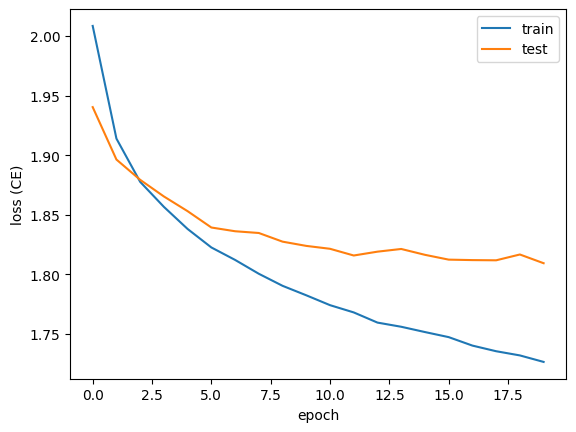

In [7]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('epoch')
plt.ylabel('loss (CE)')
plt.legend()
plt.show()

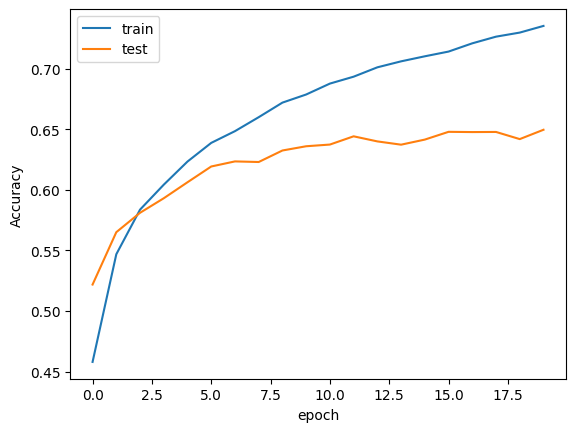

In [8]:
plt.plot(train_accuracy, label='train')
plt.plot(test_accuracy, label='test')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### There's more

In [40]:
from torchvision import utils

def visualize_kernels(tensor, ch=0, all_kernels=False, nrow=8, padding=1, title=None): 
    n,c,w,h = tensor.shape

    if all_kernels:
        tensor = tensor.view(n*c, -1, w, h)
    elif c != 3:
        tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    # Display
    plt.figure(figsize=(nrow, rows))
    if title is not None:
        plt.title(title)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.show()

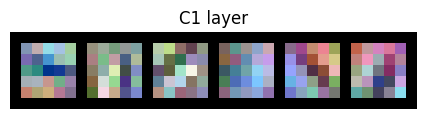

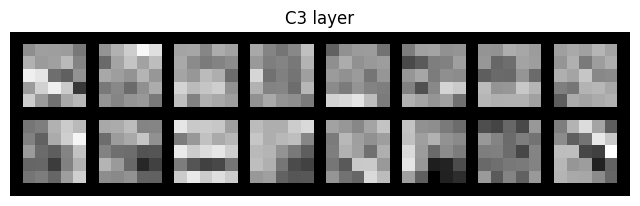

In [41]:
visualize_kernels(lenet5.c1.weight.data, all_kernels=False, title='C1 layer')
visualize_kernels(lenet5.c3.weight.data, title='C3 layer')

The torch documentation about batch normalization: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html

The batch normalization paper: https://arxiv.org/pdf/1502.03167.pdf

## Regularizing a CNN with transfer learning for object detection

### How to do it

In [1]:
import cv2
from glob import glob
import matplotlib.pyplot as plt
from ultralytics import YOLO

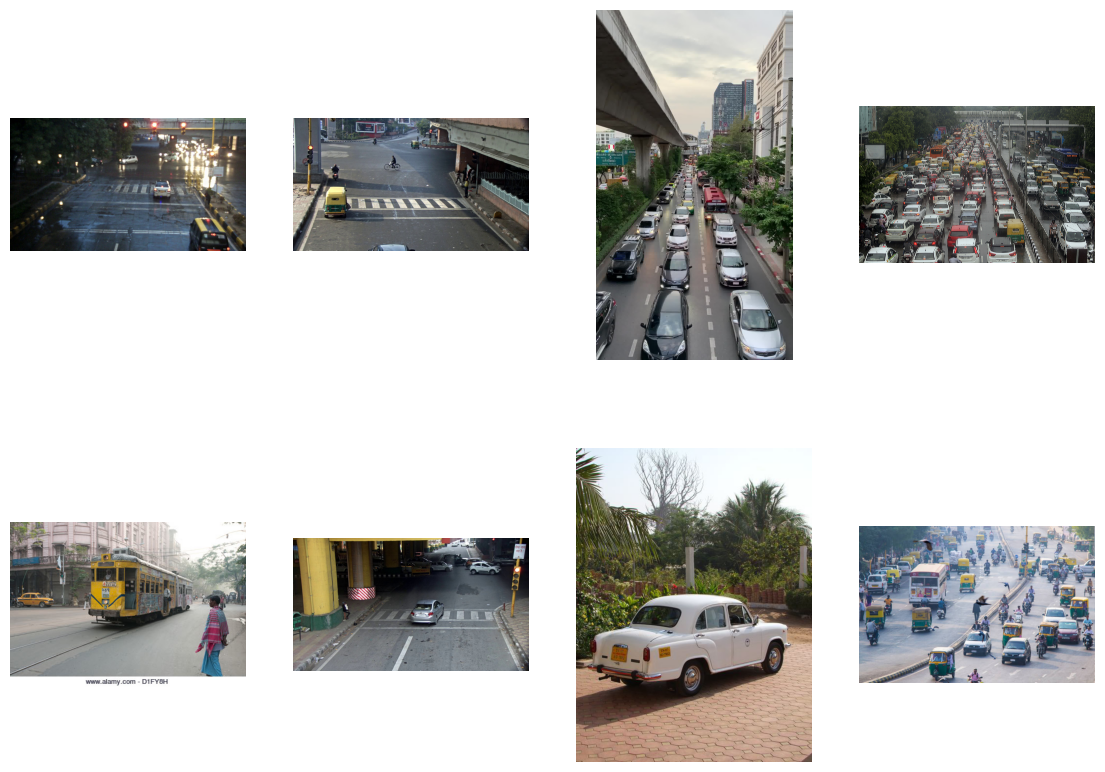

In [2]:
plt.figure(figsize=(14, 10))
# Get all images paths
images = glob('datasets/traffic/images/train/*.jpg')
# Plot 8 of them
for i, path in enumerate(images[:8]):
    img = plt.imread(path)
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.axis('off')

In [3]:
with open('datasets/traffic/labels/train/00 (10).txt') as file:
    print(file.read())
    file.close()

2 0.543893 0.609375 0.041985 0.041667
5 0.332061 0.346354 0.129771 0.182292
5 0.568702 0.479167 0.351145 0.427083



In [5]:
def plot_labels(image_path, labels_path, classes):
    image = plt.imread(image_path)
    with open(labels_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            cls, xc, yc, w, h = line.strip().split(' ')

            xc = int(float(xc)*image.shape[1])
            yc = int(float(yc)*image.shape[0])
            w = int(float(w)*image.shape[1])
            h = int(float(h)*image.shape[0])
            cv2.rectangle(image, (xc - w//2, yc - h//2), (xc + w//2 ,yc + h//2), (255,0,0), 2)
            cv2.putText(image, f'{classes[int(cls)]}', (xc-w//2, yc - h//2 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)

    file.close()
    plt.imshow(image)

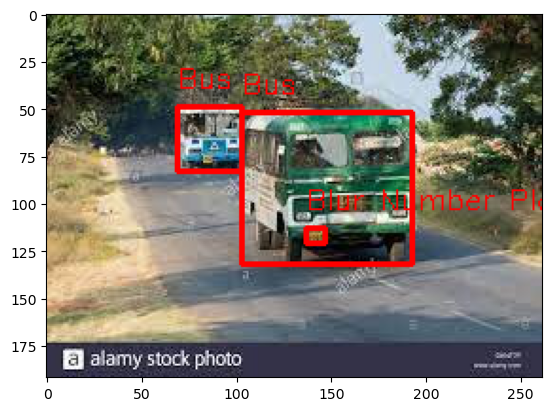

In [6]:
classes = ['Car', 'Number Plate', 'Blur Number Plate', 'Two Wheeler', 'Auto', 'Bus', 'Truck']
plot_labels(
    'datasets/traffic/images/train/00 (10).jpg', 
    'datasets/traffic/labels/train/00 (10).txt',
    classes
)

In [ ]:
# Create a new YOLO model with random weights
model = YOLO('yolov8n.yaml')

In [ ]:
# Train the model for 100 epochs
model.train(data='dataset.yaml', epochs=100, name='untrained_traffic')

(-0.5, 2399.5, 1199.5, -0.5)

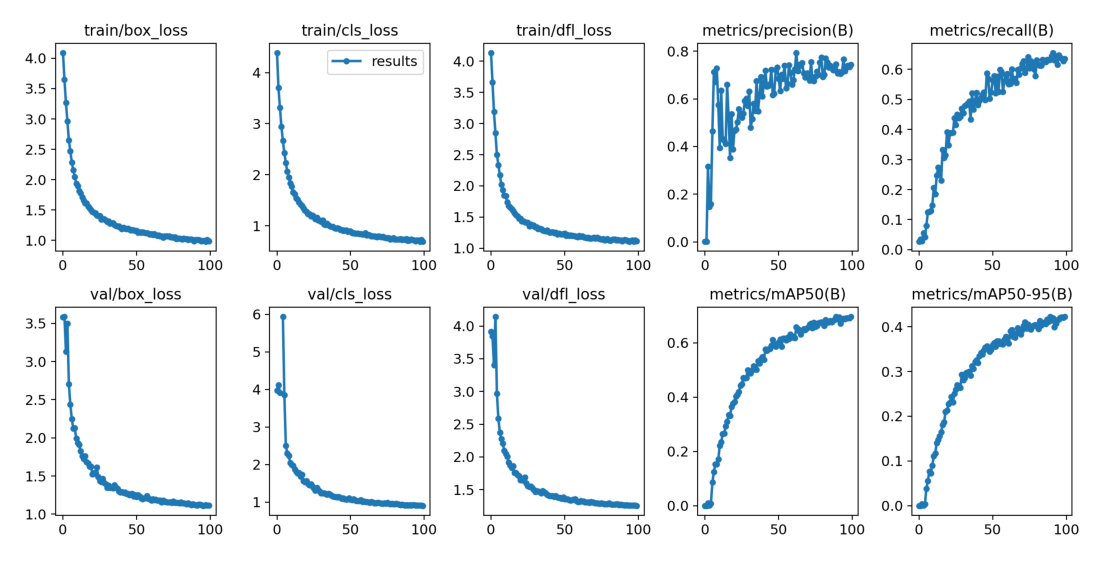

In [9]:
plt.figure(figsize=(14, 10))
plt.imshow(plt.imread('runs/detect/untrained_traffic/results.png'))
plt.axis('off')

In [13]:
def plot_results_one_image(result):
    image = result[0].orig_img.copy()
    raw_res = result[0].boxes.data
    for detection in raw_res:
        x1, y1, x2, y2, p, cls = detection.cpu().tolist()
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255,0,0), 2)
        cv2.putText(image, f'{classes[int(cls)]}', (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
    plt.imshow(image)

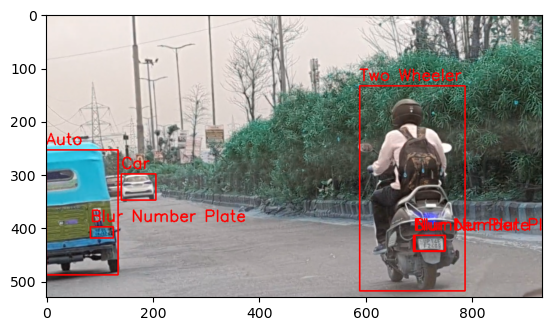

In [14]:
# Compute the model inference on a test image
result = model.predict('datasets/traffic/images/test/00 (100).png')
# Plot the results
plot_results_one_image(result)

#### Training with transfer learning

In [ ]:
# Load a pretrained YOLO model
pretrained_model = YOLO('yolov8n.pt')
# Train the model for 100 epochs
pretrained_model.train(data='dataset.yaml', epochs=100, name='pretrained_traffic')

(-0.5, 2399.5, 1199.5, -0.5)

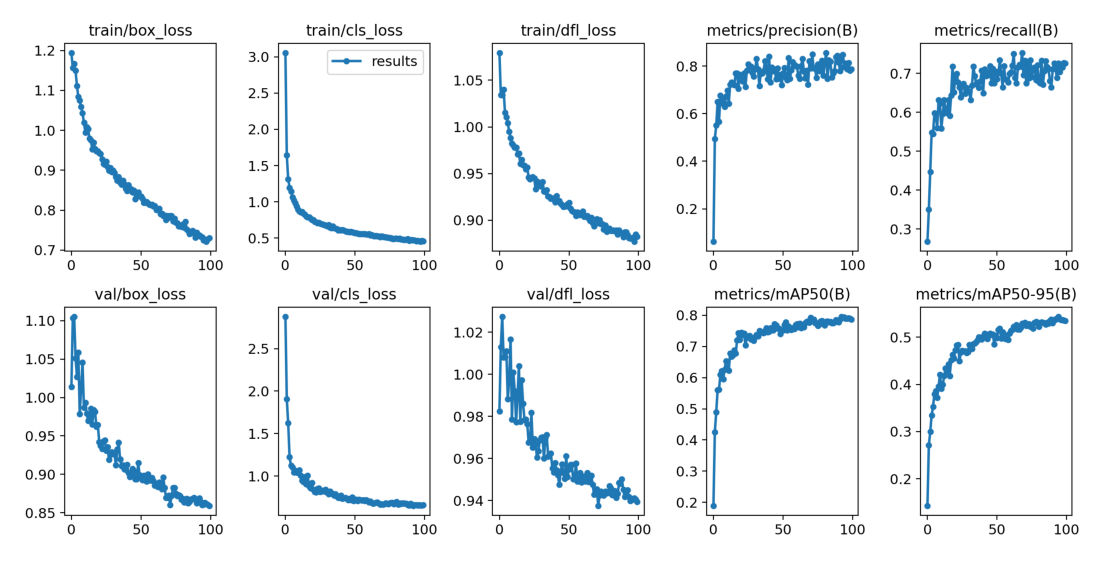

In [18]:
plt.figure(figsize=(14, 10))
plt.imshow(plt.imread('runs/detect/pretrained_traffic/results.png'))
plt.axis('off')

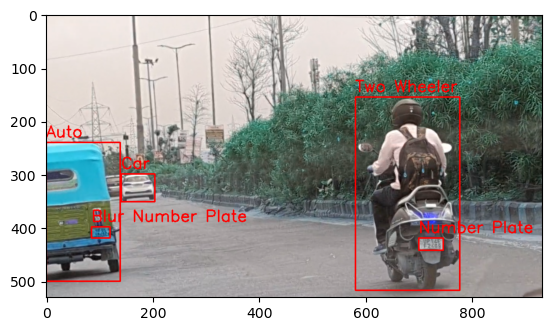

In [21]:
result = pretrained_model.predict('datasets/traffic/images/test/00 (100).png')
plot_results_one_image(result)

## Semantic segmentation using transfer learning

#### Train with imagenet weights and all weights unfreeze

In [1]:
from torch.utils.data import DataLoader, Dataset
import torch

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

import tqdm

from glob import glob

from PIL import Image

import segmentation_models_pytorch as smp

import torch.nn as nn
import torch.optim as optim

In [2]:
class DroneDataset(Dataset):

    def __init__(self, images_path: str, masks_path: str, transform, train: bool, num_classes: int = 5):
        self.images_path = sorted(glob(f'{images_path}/*.png'))
        self.masks_path = sorted(glob(f'{masks_path}/*.png'))
        self.num_classes = num_classes
        if train:
            self.images_path = self.images_path[:int(.8*len(self.images_path))]
            self.masks_path = self.masks_path[:int(.8*len(self.masks_path))]
        else:
            self.images_path = self.images_path[int(.8*len(self.images_path)):]
            self.masks_path = self.masks_path[int(.8*len(self.masks_path)):]            
        self.transform = transform
        
    def __len__(self):
        return len(self.images_path)
    """
    def mask_to_class(self, mask):
        target = torch.from_numpy(mask)
        h,w = target.shape[0],target.shape[1]
        masks = torch.empty(h, w, dtype=torch.long)
        colors = torch.unique(target.view(-1,target.size(2)),dim=0).numpy()
        target = target.permute(2, 0, 1).contiguous()
        mapping = {tuple(c): t for c, t in zip(colors.tolist(), range(len(colors)))}
        for k in mapping:
            idx = (target==torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))
            validx = (idx.sum(0) == 3) 
            masks[validx] = torch.tensor(mapping[k], dtype=torch.long)
        return masks
    """
    
    def __getitem__(self, idx):
        image = np.array(Image.open(self.images_path[idx]))
        mask = np.array(Image.open(self.masks_path[idx]))
        # Convert mask to one hot encoding
        #mask = torch.nn.functional.one_hot(torch.tensor(mask, dtype=torch.long), num_classes=self.num_classes)
        #return self.transform(image), mask.permute(2, 0, 1).float()
        return self.transform(image), torch.tensor(mask, dtype=torch.long)


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
batch_size = 4#16
learning_rate = 0.005
classes = ['obstacles', 'water', 'soft-surfaces', 'moving-objects', 'landing-zones']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
train_dataset = DroneDataset(
    'drone_dataset/classes_dataset/classes_dataset/original_images/',
    'drone_dataset/classes_dataset/classes_dataset/label_images_semantic/',
    transform, 
    train=True
)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DroneDataset(
    'drone_dataset/classes_dataset/classes_dataset/original_images/',
    'drone_dataset/classes_dataset/classes_dataset/label_images_semantic/',
    transform, 
    train=False
)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

(-0.5, 959.5, 735.5, -0.5)

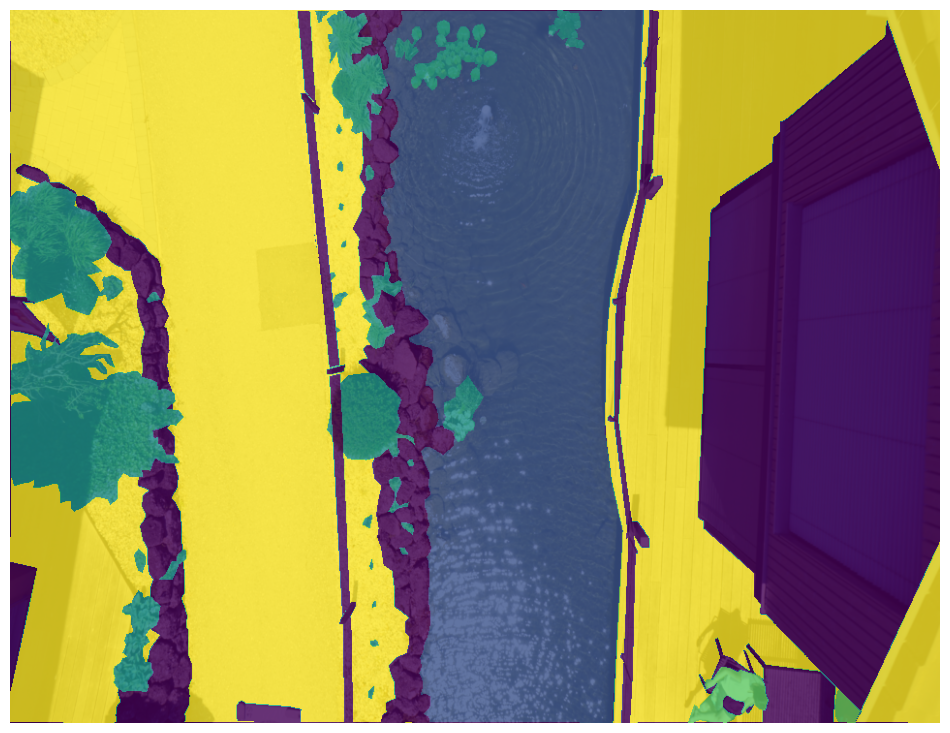

In [6]:
# Get a batch of images and labels
images, labels = next(iter(train_dataloader))
# Plot the image and overlay the labels
plt.figure(figsize=(12, 10))
plt.imshow(images[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
plt.imshow(labels[0], alpha = 0.8)
plt.axis('off')

In [7]:
model = smp.Unet(
                encoder_name='efficientnet-b5',#'timm-mobilenetv3_large_100',
                encoder_weights='imagenet',
                in_channels=3,
                classes=len(classes),
            )

In [8]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True)

In [9]:
def compute_metrics(stats):
    tp = torch.cat([x["tp"] for x in stats])
    fp = torch.cat([x["fp"] for x in stats])
    fn = torch.cat([x["fn"] for x in stats])
    tn = torch.cat([x["tn"] for x in stats])
    
    iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction='micro')
    f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction='micro')
    return iou, f1_score

In [10]:
def train_unet(model, train_dataloader, test_dataloader, criterion, device, epochs: int = 10, num_classes: int = 5, scheduler=None):
    train_metrics = {'loss': [], 'iou': [], 'f1': [], 'lr': []}
    test_metrics = {'loss': [], 'iou': [], 'f1': []}
    
    model = model.to(device)
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        # Train
        model.train()
        #running_loss = 0.0
        train_stats = []

        for i, data in tqdm.tqdm(enumerate(train_dataloader, 0)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            # Compute loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # compute statistics
            # running_loss += loss.item()
            tp, fp, fn, tn = smp.metrics.get_stats(torch.argmax(outputs, dim=1), labels, mode='multiclass', num_classes=num_classes)
            train_stats.append({'tp': tp, 'fp': fp, 'fn':fn, 'tn': tn, 'loss': loss.item()})

        # Eval
        model.eval()
        test_stats = []

        with torch.no_grad():
            for i, data in enumerate(test_dataloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                # forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                # Compute stats
                #test_loss += loss.item()
                tp, fp, fn, tn = smp.metrics.get_stats(torch.argmax(outputs, dim=1), labels, mode='multiclass', num_classes=num_classes)
                test_stats.append({'tp': tp, 'fp': fp, 'fn':fn, 'tn': tn, 'loss': loss.item()})

        if scheduler is not None:
            train_metrics['lr'].append(scheduler.get_last_lr())
            scheduler.step()
        
        train_metrics['loss'].append(sum([x['loss'] for x in train_stats]) / len(train_dataloader))
        test_metrics['loss'].append(sum([x['loss'] for x in test_stats]) / len(test_dataloader))
        iou, f1 = compute_metrics(train_stats)
        train_metrics['iou'].append(iou)
        train_metrics['f1'].append(f1)
        iou, f1 = compute_metrics(test_stats)
        test_metrics['iou'].append(iou)
        test_metrics['f1'].append(f1)
        
        print(f"[{epoch + 1}] train loss: {train_metrics['loss'][-1]:.3f} IoU: {train_metrics['iou'][-1]:.3f} | \
                test loss: {test_metrics['loss'][-1]:.3f} IoU: {test_metrics['iou'][-1]:.3f}")
    return train_metrics, test_metrics

In [11]:
train_metrics, test_metrics = train_unet(model, train_dataloader, test_dataloader, criterion, device, epochs=50, num_classes=len(classes))

80it [00:42,  1.90it/s]


[1] train loss: 0.462 IoU: 0.633 |                 test loss: 0.617 IoU: 0.343


80it [00:41,  1.91it/s]


[2] train loss: 0.353 IoU: 0.696 |                 test loss: 0.521 IoU: 0.615


80it [00:41,  1.92it/s]


[3] train loss: 0.303 IoU: 0.732 |                 test loss: 0.633 IoU: 0.273


80it [00:41,  1.94it/s]


[4] train loss: 0.293 IoU: 0.728 |                 test loss: 0.565 IoU: 0.408


80it [00:41,  1.93it/s]


[5] train loss: 0.298 IoU: 0.735 |                 test loss: 0.426 IoU: 0.654


80it [00:41,  1.94it/s]


[6] train loss: 0.259 IoU: 0.777 |                 test loss: 0.343 IoU: 0.663


80it [00:40,  1.96it/s]


[7] train loss: 0.250 IoU: 0.786 |                 test loss: 0.304 IoU: 0.760


80it [00:40,  1.96it/s]


[8] train loss: 0.220 IoU: 0.792 |                 test loss: 0.337 IoU: 0.673


80it [00:40,  1.96it/s]


[9] train loss: 0.225 IoU: 0.774 |                 test loss: 0.451 IoU: 0.660


80it [00:40,  1.96it/s]


[10] train loss: 0.218 IoU: 0.790 |                 test loss: 0.459 IoU: 0.490


80it [00:40,  1.96it/s]


[11] train loss: 0.197 IoU: 0.816 |                 test loss: 0.213 IoU: 0.767


80it [00:40,  1.96it/s]


[12] train loss: 0.183 IoU: 0.827 |                 test loss: 0.320 IoU: 0.690


80it [00:40,  1.96it/s]


[13] train loss: 0.181 IoU: 0.824 |                 test loss: 0.267 IoU: 0.746


80it [00:40,  1.96it/s]


[14] train loss: 0.165 IoU: 0.836 |                 test loss: 0.239 IoU: 0.776


80it [00:40,  1.96it/s]


[15] train loss: 0.178 IoU: 0.833 |                 test loss: 0.492 IoU: 0.687


80it [00:40,  1.96it/s]


[16] train loss: 0.164 IoU: 0.838 |                 test loss: 0.210 IoU: 0.773


80it [00:40,  1.96it/s]


[17] train loss: 0.154 IoU: 0.846 |                 test loss: 0.237 IoU: 0.768


80it [00:40,  1.96it/s]


[18] train loss: 0.166 IoU: 0.841 |                 test loss: 0.200 IoU: 0.796


80it [00:40,  1.96it/s]


[19] train loss: 0.149 IoU: 0.850 |                 test loss: 0.218 IoU: 0.812


80it [00:40,  1.96it/s]


[20] train loss: 0.157 IoU: 0.836 |                 test loss: 0.300 IoU: 0.706


80it [00:40,  1.96it/s]


[21] train loss: 0.150 IoU: 0.852 |                 test loss: 0.190 IoU: 0.828


80it [00:40,  1.96it/s]


[22] train loss: 0.137 IoU: 0.857 |                 test loss: 0.165 IoU: 0.830


80it [00:41,  1.91it/s]


[23] train loss: 0.145 IoU: 0.850 |                 test loss: 0.314 IoU: 0.652


80it [00:41,  1.93it/s]


[24] train loss: 0.149 IoU: 0.839 |                 test loss: 0.195 IoU: 0.803


80it [00:41,  1.94it/s]


[25] train loss: 0.127 IoU: 0.867 |                 test loss: 0.145 IoU: 0.845


80it [00:41,  1.94it/s]


[26] train loss: 0.131 IoU: 0.867 |                 test loss: 0.202 IoU: 0.831


80it [00:41,  1.94it/s]


[27] train loss: 0.130 IoU: 0.864 |                 test loss: 0.248 IoU: 0.756


80it [00:41,  1.93it/s]


[28] train loss: 0.117 IoU: 0.871 |                 test loss: 0.161 IoU: 0.847


80it [00:41,  1.94it/s]


[29] train loss: 0.110 IoU: 0.882 |                 test loss: 0.133 IoU: 0.859


80it [00:41,  1.92it/s]


[30] train loss: 0.105 IoU: 0.885 |                 test loss: 0.192 IoU: 0.816


80it [00:41,  1.94it/s]


[31] train loss: 0.126 IoU: 0.871 |                 test loss: 0.328 IoU: 0.731


80it [00:41,  1.91it/s]


[32] train loss: 0.130 IoU: 0.868 |                 test loss: 0.175 IoU: 0.825


80it [00:42,  1.90it/s]


[33] train loss: 0.115 IoU: 0.878 |                 test loss: 0.187 IoU: 0.837


80it [00:41,  1.91it/s]


[34] train loss: 0.115 IoU: 0.875 |                 test loss: 0.171 IoU: 0.822


80it [00:41,  1.93it/s]


[35] train loss: 0.121 IoU: 0.870 |                 test loss: 0.203 IoU: 0.790


80it [00:41,  1.93it/s]


[36] train loss: 0.144 IoU: 0.835 |                 test loss: 0.184 IoU: 0.822


80it [00:41,  1.91it/s]


[37] train loss: 0.110 IoU: 0.880 |                 test loss: 0.162 IoU: 0.833


80it [00:41,  1.91it/s]


[38] train loss: 0.153 IoU: 0.851 |                 test loss: 0.397 IoU: 0.628


80it [00:41,  1.92it/s]


[39] train loss: 0.133 IoU: 0.865 |                 test loss: 0.211 IoU: 0.783


80it [00:42,  1.90it/s]


[40] train loss: 0.130 IoU: 0.860 |                 test loss: 0.402 IoU: 0.656


80it [00:41,  1.95it/s]


[41] train loss: 0.163 IoU: 0.843 |                 test loss: 0.218 IoU: 0.816


80it [00:41,  1.92it/s]


[42] train loss: 0.121 IoU: 0.866 |                 test loss: 0.528 IoU: 0.411


80it [00:40,  1.95it/s]


[43] train loss: 0.142 IoU: 0.845 |                 test loss: 0.200 IoU: 0.816


80it [00:41,  1.95it/s]


[44] train loss: 0.120 IoU: 0.872 |                 test loss: 0.152 IoU: 0.835


80it [00:41,  1.94it/s]


[45] train loss: 0.117 IoU: 0.876 |                 test loss: 0.161 IoU: 0.841


80it [00:41,  1.94it/s]


[46] train loss: 0.109 IoU: 0.882 |                 test loss: 0.134 IoU: 0.852


80it [00:40,  1.96it/s]


[47] train loss: 0.092 IoU: 0.895 |                 test loss: 0.141 IoU: 0.858


80it [00:40,  1.96it/s]


[48] train loss: 0.096 IoU: 0.893 |                 test loss: 0.133 IoU: 0.868


80it [00:40,  1.96it/s]


[49] train loss: 0.094 IoU: 0.895 |                 test loss: 0.135 IoU: 0.858


80it [00:40,  1.96it/s]


[50] train loss: 0.084 IoU: 0.900 |                 test loss: 0.142 IoU: 0.862


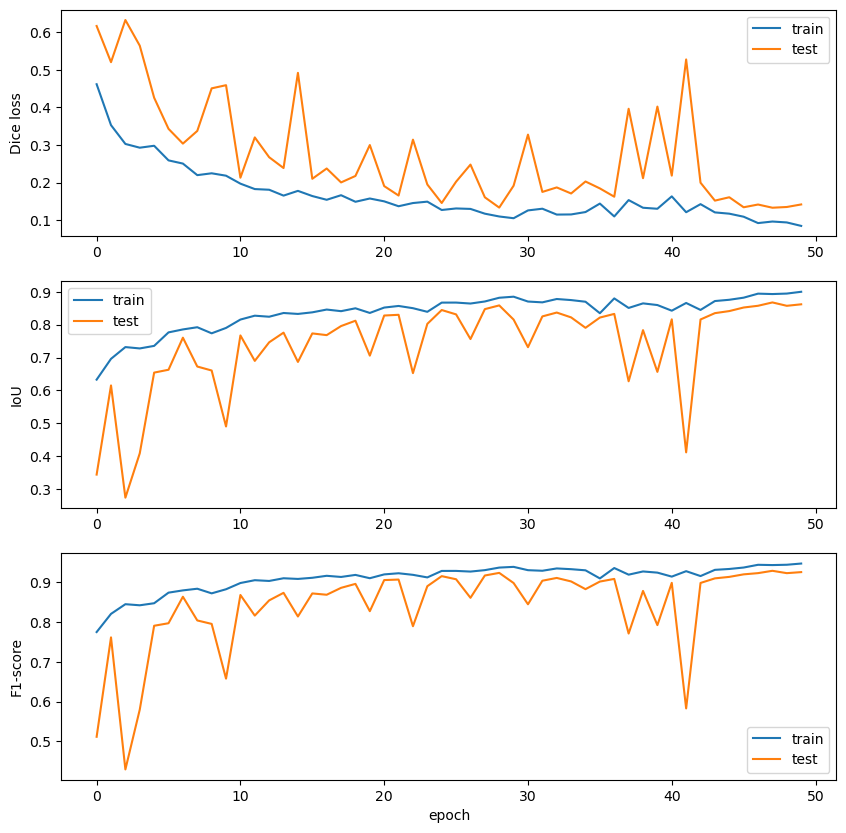

In [12]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.plot(train_metrics['loss'], label='train')
plt.plot(test_metrics['loss'], label='test')
plt.ylabel('Dice loss')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(train_metrics['iou'], label='train')
plt.plot(test_metrics['iou'], label='test')
plt.ylabel('IoU')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(train_metrics['f1'], label='train')
plt.plot(test_metrics['f1'], label='test')
plt.xlabel('epoch')
plt.ylabel('F1-score')
plt.legend()
plt.show()

#### Fine tuning pretrained model by freezing layers

In [11]:
def freeze_encoder(model, max_level: int = None):
    for i, child in enumerate(model.encoder.children()):
        if max_level is not None and i >= max_level:
                return
        for param in child.parameters():
            param.requires_grad = False
    return

""" For mobileNet
def freeze_encoder(model, max_level: int = None):
    for child in model.encoder.children():
        for i, block in enumerate(child.blocks):
            if max_level is not None and i >= max_level:
                return
            for param in block.parameters():
                param.requires_grad = False
    return
"""
def unfreeze(model):
    for child in model.children():
        for param in child.parameters():
            param.requires_grad = True
    return

In [12]:
model = smp.Unet(
                encoder_name='efficientnet-b5',#'timm-mobilenetv3_large_100',
                encoder_weights='imagenet',
                in_channels=3,
                classes=len(classes),
            )
print('Total number of trainable parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

Total number of trainable parameters: 31216581


In [13]:
# Freeze the of the encoder
freeze_encoder(model, 3)
print('Total number of trainable parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

Total number of trainable parameters: 3928469


In [14]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [15]:
train_metrics, test_metrics = train_unet(model, train_dataloader, test_dataloader, criterion, device, epochs=20, num_classes=len(classes), scheduler=scheduler)

80it [00:21,  3.74it/s]


[1] train loss: 0.405 IoU: 0.633 |                 test loss: 0.359 IoU: 0.649


80it [00:20,  3.89it/s]


[2] train loss: 0.287 IoU: 0.726 |                 test loss: 0.334 IoU: 0.700


80it [00:20,  3.89it/s]


[3] train loss: 0.265 IoU: 0.731 |                 test loss: 0.212 IoU: 0.790


80it [00:20,  3.87it/s]


[4] train loss: 0.214 IoU: 0.768 |                 test loss: 0.192 IoU: 0.822


80it [00:20,  3.88it/s]


[5] train loss: 0.187 IoU: 0.801 |                 test loss: 0.181 IoU: 0.825


80it [00:20,  3.87it/s]


[6] train loss: 0.175 IoU: 0.810 |                 test loss: 0.166 IoU: 0.836


80it [00:20,  3.86it/s]


[7] train loss: 0.168 IoU: 0.816 |                 test loss: 0.162 IoU: 0.849


80it [00:20,  3.86it/s]


[8] train loss: 0.164 IoU: 0.822 |                 test loss: 0.168 IoU: 0.834


80it [00:20,  3.87it/s]


[9] train loss: 0.148 IoU: 0.834 |                 test loss: 0.141 IoU: 0.850


80it [00:20,  3.83it/s]


[10] train loss: 0.138 IoU: 0.854 |                 test loss: 0.135 IoU: 0.856


80it [00:20,  3.86it/s]


[11] train loss: 0.131 IoU: 0.860 |                 test loss: 0.151 IoU: 0.854


80it [00:20,  3.86it/s]


[12] train loss: 0.132 IoU: 0.862 |                 test loss: 0.134 IoU: 0.852


80it [00:20,  3.86it/s]


[13] train loss: 0.127 IoU: 0.862 |                 test loss: 0.125 IoU: 0.845


80it [00:20,  3.86it/s]


[14] train loss: 0.118 IoU: 0.868 |                 test loss: 0.115 IoU: 0.870


80it [00:20,  3.87it/s]


[15] train loss: 0.111 IoU: 0.877 |                 test loss: 0.119 IoU: 0.861


80it [00:20,  3.86it/s]


[16] train loss: 0.104 IoU: 0.882 |                 test loss: 0.118 IoU: 0.872


80it [00:20,  3.87it/s]


[17] train loss: 0.108 IoU: 0.879 |                 test loss: 0.128 IoU: 0.861


80it [00:20,  3.85it/s]


[18] train loss: 0.100 IoU: 0.888 |                 test loss: 0.113 IoU: 0.873


80it [00:20,  3.85it/s]


[19] train loss: 0.094 IoU: 0.892 |                 test loss: 0.117 IoU: 0.878


80it [00:20,  3.86it/s]


[20] train loss: 0.102 IoU: 0.882 |                 test loss: 0.111 IoU: 0.873


In [16]:
unfreeze(model)
print('Total number of trainable parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

Total number of trainable parameters: 31216581


In [17]:
train_metrics_unfreeze, test_metrics_unfreeze = train_unet(model, train_dataloader, test_dataloader, criterion, device, epochs=30, num_classes=len(classes), scheduler=scheduler)

80it [00:40,  1.95it/s]


[1] train loss: 0.208 IoU: 0.809 |                 test loss: 0.233 IoU: 0.805


80it [00:41,  1.94it/s]


[2] train loss: 0.153 IoU: 0.849 |                 test loss: 0.214 IoU: 0.795


80it [00:41,  1.95it/s]


[3] train loss: 0.146 IoU: 0.851 |                 test loss: 0.269 IoU: 0.750


80it [00:41,  1.93it/s]


[4] train loss: 0.124 IoU: 0.867 |                 test loss: 0.154 IoU: 0.873


80it [00:41,  1.93it/s]


[5] train loss: 0.115 IoU: 0.878 |                 test loss: 0.156 IoU: 0.862


80it [00:40,  1.95it/s]


[6] train loss: 0.105 IoU: 0.886 |                 test loss: 0.197 IoU: 0.788


80it [00:41,  1.95it/s]


[7] train loss: 0.117 IoU: 0.878 |                 test loss: 0.130 IoU: 0.871


80it [00:41,  1.94it/s]


[8] train loss: 0.099 IoU: 0.893 |                 test loss: 0.121 IoU: 0.863


80it [00:40,  1.96it/s]


[9] train loss: 0.092 IoU: 0.901 |                 test loss: 0.139 IoU: 0.849


80it [00:40,  1.96it/s]


[10] train loss: 0.085 IoU: 0.903 |                 test loss: 0.108 IoU: 0.876


80it [00:40,  1.96it/s]


[11] train loss: 0.082 IoU: 0.907 |                 test loss: 0.106 IoU: 0.885


80it [00:40,  1.96it/s]


[12] train loss: 0.074 IoU: 0.915 |                 test loss: 0.104 IoU: 0.884


80it [00:41,  1.92it/s]


[13] train loss: 0.069 IoU: 0.920 |                 test loss: 0.095 IoU: 0.883


80it [00:41,  1.94it/s]


[14] train loss: 0.068 IoU: 0.921 |                 test loss: 0.094 IoU: 0.886


80it [00:40,  1.96it/s]


[15] train loss: 0.064 IoU: 0.924 |                 test loss: 0.091 IoU: 0.886


80it [00:40,  1.96it/s]


[16] train loss: 0.061 IoU: 0.927 |                 test loss: 0.091 IoU: 0.887


80it [00:40,  1.96it/s]


[17] train loss: 0.060 IoU: 0.928 |                 test loss: 0.092 IoU: 0.889


80it [00:40,  1.96it/s]


[18] train loss: 0.059 IoU: 0.929 |                 test loss: 0.096 IoU: 0.891


80it [00:40,  1.96it/s]


[19] train loss: 0.057 IoU: 0.931 |                 test loss: 0.106 IoU: 0.883


80it [00:40,  1.96it/s]


[20] train loss: 0.063 IoU: 0.928 |                 test loss: 0.099 IoU: 0.885


80it [00:40,  1.96it/s]


[21] train loss: 0.059 IoU: 0.931 |                 test loss: 0.085 IoU: 0.892


80it [00:40,  1.96it/s]


[22] train loss: 0.057 IoU: 0.932 |                 test loss: 0.088 IoU: 0.892


80it [00:40,  1.96it/s]


[23] train loss: 0.055 IoU: 0.933 |                 test loss: 0.089 IoU: 0.887


80it [00:40,  1.96it/s]


[24] train loss: 0.054 IoU: 0.936 |                 test loss: 0.091 IoU: 0.889


80it [00:40,  1.96it/s]


[25] train loss: 0.051 IoU: 0.939 |                 test loss: 0.086 IoU: 0.892


80it [00:40,  1.96it/s]


[26] train loss: 0.051 IoU: 0.939 |                 test loss: 0.083 IoU: 0.885


80it [00:40,  1.96it/s]


[27] train loss: 0.049 IoU: 0.941 |                 test loss: 0.083 IoU: 0.893


80it [00:40,  1.96it/s]


[28] train loss: 0.047 IoU: 0.942 |                 test loss: 0.080 IoU: 0.892


80it [00:40,  1.96it/s]


[29] train loss: 0.048 IoU: 0.943 |                 test loss: 0.086 IoU: 0.892


80it [00:40,  1.96it/s]


[30] train loss: 0.048 IoU: 0.943 |                 test loss: 0.082 IoU: 0.893


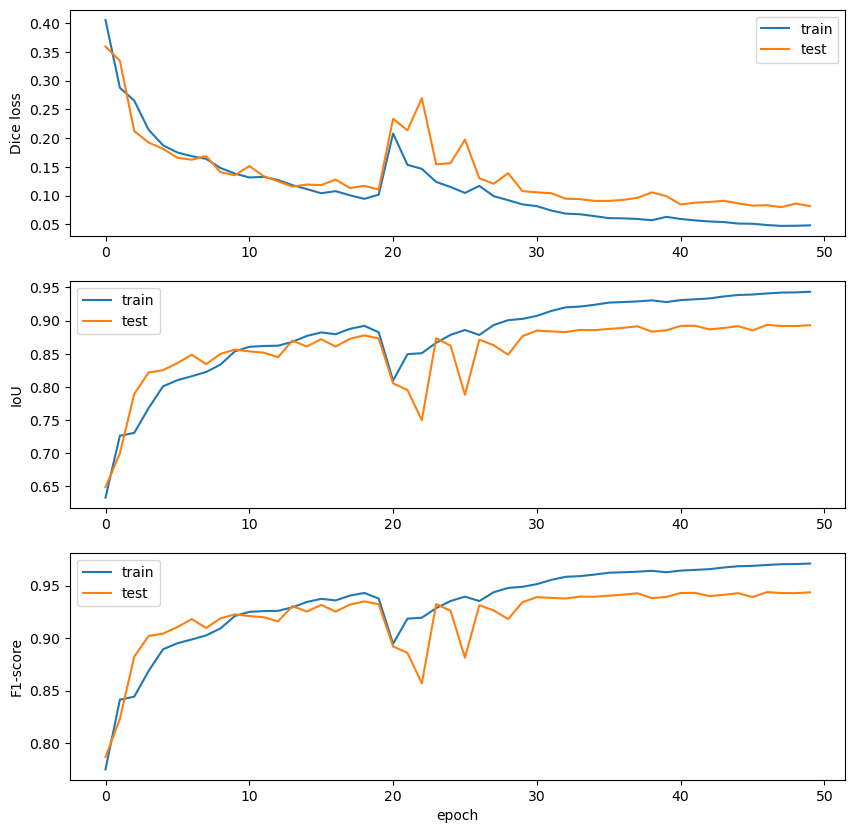

In [18]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.plot(train_metrics['loss'] + train_metrics_unfreeze['loss'], label='train')
plt.plot(test_metrics['loss'] + test_metrics_unfreeze['loss'], label='test')
plt.ylabel('Dice loss')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(train_metrics['iou'] + train_metrics_unfreeze['iou'], label='train')
plt.plot(test_metrics['iou'] + test_metrics_unfreeze['iou'], label='test')
plt.ylabel('IoU')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(train_metrics['f1'] + train_metrics_unfreeze['f1'], label='train')
plt.plot(test_metrics['f1'] + test_metrics_unfreeze['f1'], label='test')
plt.xlabel('epoch')
plt.ylabel('F1-score')
plt.legend()
plt.show()

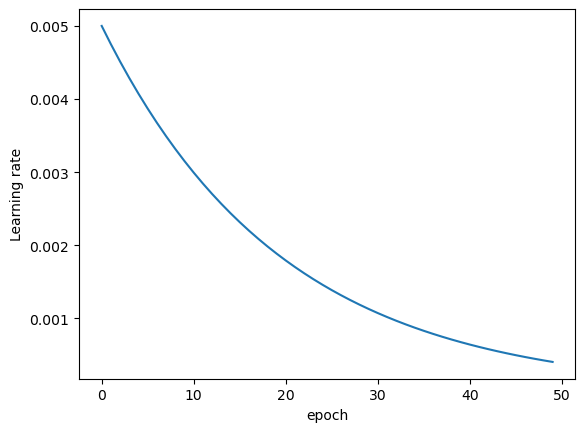

In [19]:
plt.plot(train_metrics['lr'] + train_metrics_unfreeze['lr'])
plt.xlabel('epoch')
plt.ylabel('Learning rate')
plt.show()